# Learning from Examples: Line Fitting

We want to fit a straight line to data (i.e., perform linear regression). The general approach is applicable to other model classes as well.

We will compare:

* Grid search over the loss function
* The analytical solution
* Gradient descent
* Stochastic gradient descent (SGD with mini-batches)


## Simulate some data with noise

**Unknown function:** $y = f(x) = w_1x + w_0 + N(0,1)$ with $w_0 = 3$ and $w_1 = 7$

In [119]:
f <- function(x, w0, w1) w1 * x + w0 + rnorm(length(x), mean = 0, sd = 1)

Simulate 100 examples $(x, y)$ from $f$. We randomly choose the data in the $[0,1]$ interval for $x$.

In [120]:
N <- 1000
real_w0 <- 3
real_w1 <- 7

In [121]:
x <- runif(N, 0, 1)
y <-  f(x, real_w0, real_w1)

In [122]:
xy <- data.frame(x, y)
head(xy)

,x,y
,<dbl>,<dbl>
1,0.7787155,9.252333
2,0.1635301,5.007700
3,0.2760296,6.156192
4,0.5976825,7.385234
5,0.3259888,4.876121
6,0.3053758,3.555535


Plot the simulated data and add the 

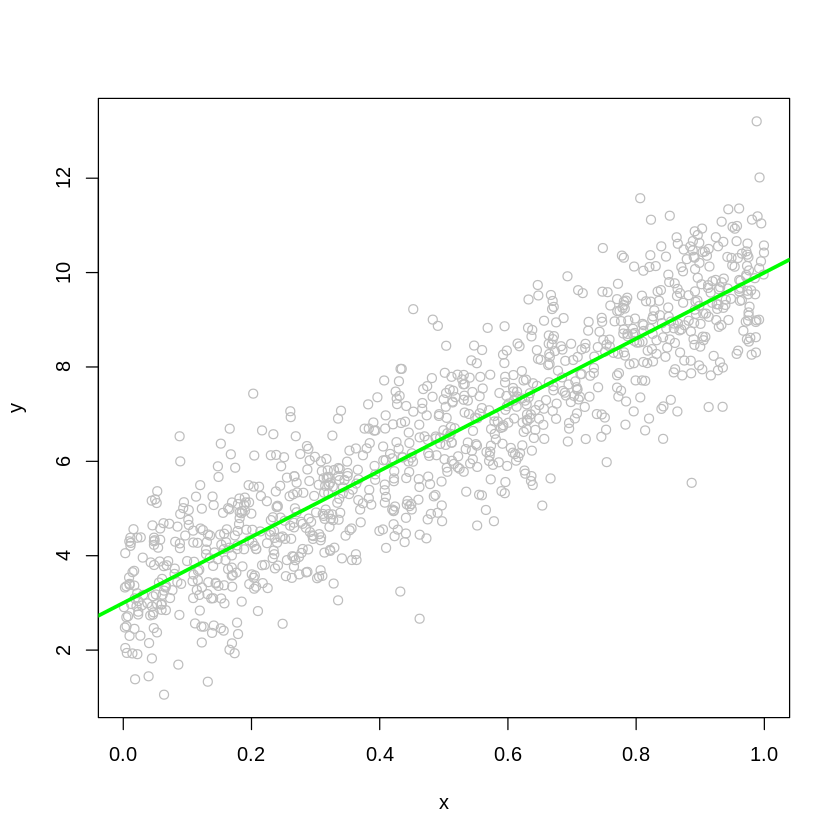

In [123]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "green", lwd = 3)

## Define the Hypothesis and the Loss Function

### Hypothesis space: Line equations 

$h_w(x) = \hat{y} = w_1 x + w_0$

In [124]:
y_hat <- function(x, w0, w1) w1 * x + w0

### Loss function: Squared-error loss

$Loss(h_w) = \sum_{j=1}^N (y_j - h_w(x_j))^2$

In [125]:
L2 <- function(y, y_hat) sum((y - y_hat)^2)

## Grid search

Create a grid of w0 and w1 values

In [126]:
resolution <- 25
grid <- data.frame(
  w0 = rep(seq(0, 10, length.out = resolution), times = resolution),
  w1 = rep(seq(0, 10, length.out = resolution), each = resolution)
)

In [127]:
grid$L2 <- with(xy, 
  apply(grid, MARGIN = 1, FUN = function(w) 
    L2(y, y_hat(x, w["w0"], w["w1"]))
  )
)

Find minimum grid cell

In [128]:
opt <- grid[which.min(grid$L2), ]
opt

,w0,w1,L2
,<dbl>,<dbl>,<dbl>
433,2.916667,7.083333,995.8069


Plot loss function surface

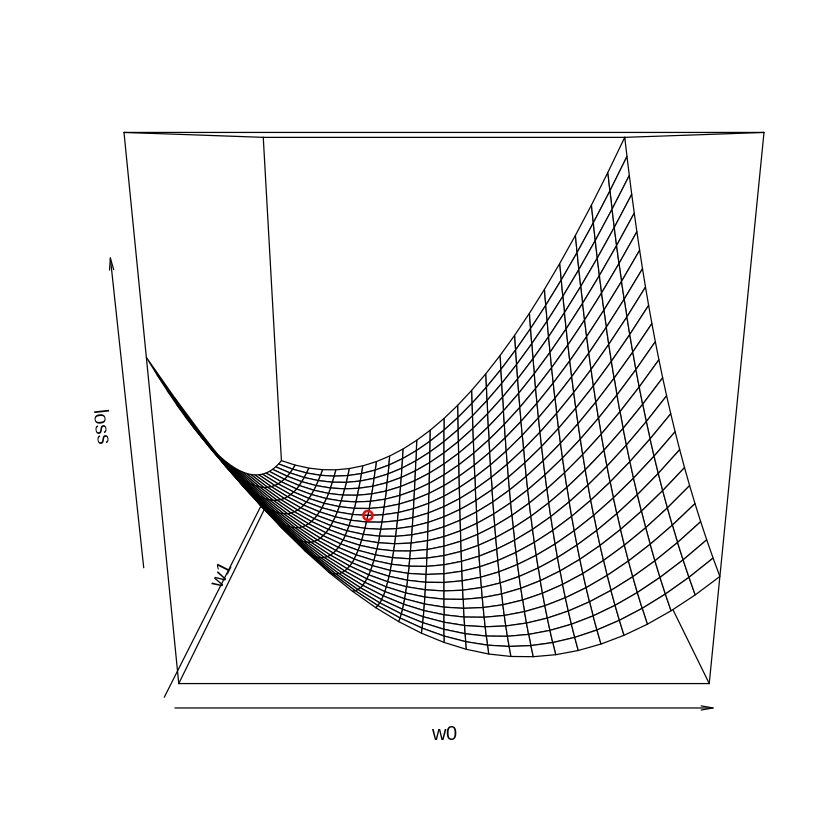

In [129]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
points(
  trans3d(
    x = opt[,"w0"]/max(grid[,"w0"]), 
    y = opt[,"w1"]/max(grid[,"w1"]), 
    z = opt[,"L2"], 
    pmat = pmat), 
  col = "red", lwd = 2)

plot regression line

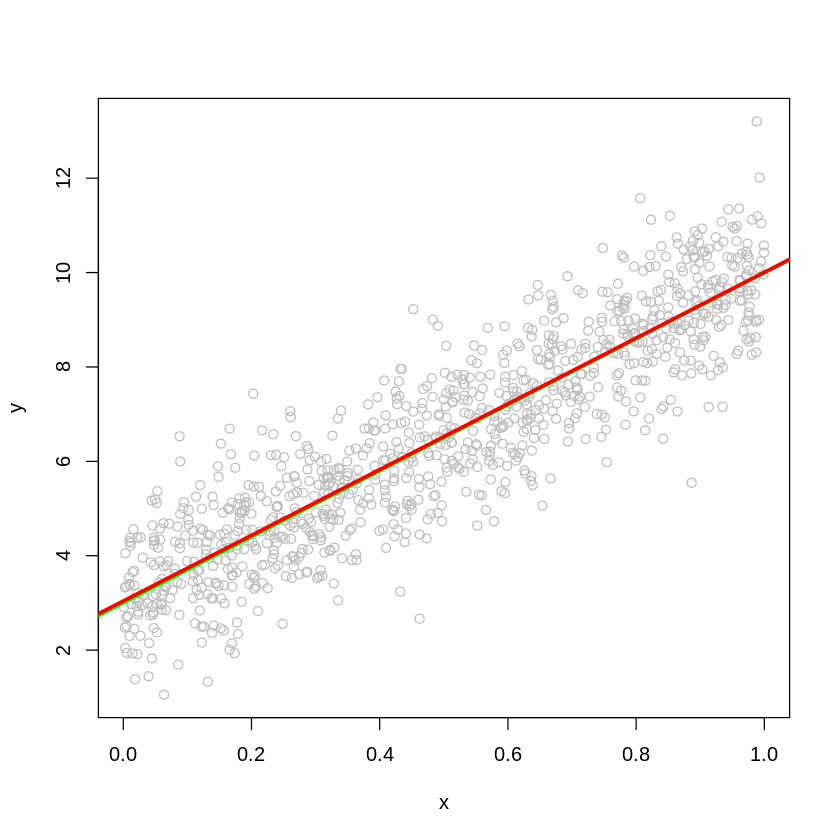

In [130]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "green", lwd = 3)
abline(a = w0, b = w1, col = "red", lwd = 3)

## Analytic solution

Loss is minimized by setting the gradient of the loss function to 0.

$\frac{\partial}{\partial w_1}Loss(h_w) = 0$ and $\frac{\partial}{\partial w_0}Loss(h_w) = 0$

Solution:

$w_1 = \frac{N(\sum x_j y_j) - (\sum x_j)(\sum y_j)}{N(\sum x_j^2) - (\sum x_j)^2}$

$w_0 = \frac{\sum y_j - w_1 (\sum x_j)}{N}$

In [131]:
w1 <- with(xy, (N * sum(x*y) - sum(x)*sum(y)) / (N * sum(x^2) - sum(x)^2))
w1

[1] 6.988435

In [132]:
w0 <- with(xy, (sum(y) - w1 * sum(x)) / N)
w0

[1] 3.004928

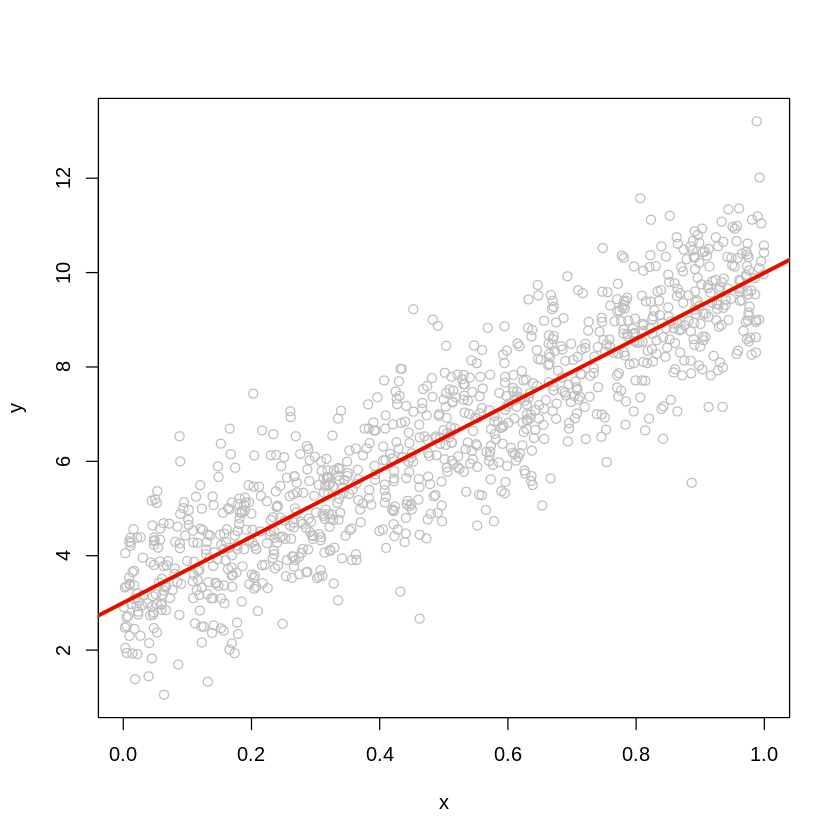

In [133]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "green", lwd = 3)
abline(a = w0, b = w1, col = "red", lwd = 3)

## Gradient descent

This is the minimization analog to hill climbing. The algorithm starts with a point in the search space. It  estimates the gradient in that point and moves a small step in the steepest downhill direction. This is repeated until it converges on a point representing a (local) minimum loss. 

The update step is

$$w_i \leftarrow w_i - \alpha \frac{\partial}{\partial w_i} Loss(\mathbf{w})$$

where $\alpha$ is called the step size. The step size can be fixed (a hyperparameter) or we can decrease it over time.

_Notes:_ 
* The loss function needs to be differentiable.
* The loss function for linear regression is convex which means that there are no local minima.

### Batch gradient descent

In [134]:
line_BGD <- function(xy, alpha = 0.0001, eps = 1e-3) {
  
  # start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  # we use loss improvement > eps to check for convergence
  step <- 0
  improvement <- Inf
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  # update weights
  while (improvement > eps) {
    old_loss <- loss
    step <- step + 1
    
    # update using the gradient
      w0 <- with(xy, w0 + alpha * sum(y - y_hat(x, w0, w1)))
    w1 <- with(xy, w1 + alpha * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
    improvement <- old_loss - loss
  
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [135]:
w <- line_BGD(xy) 
w$w

w0       w1 
3.020136 6.960156

Learning curve

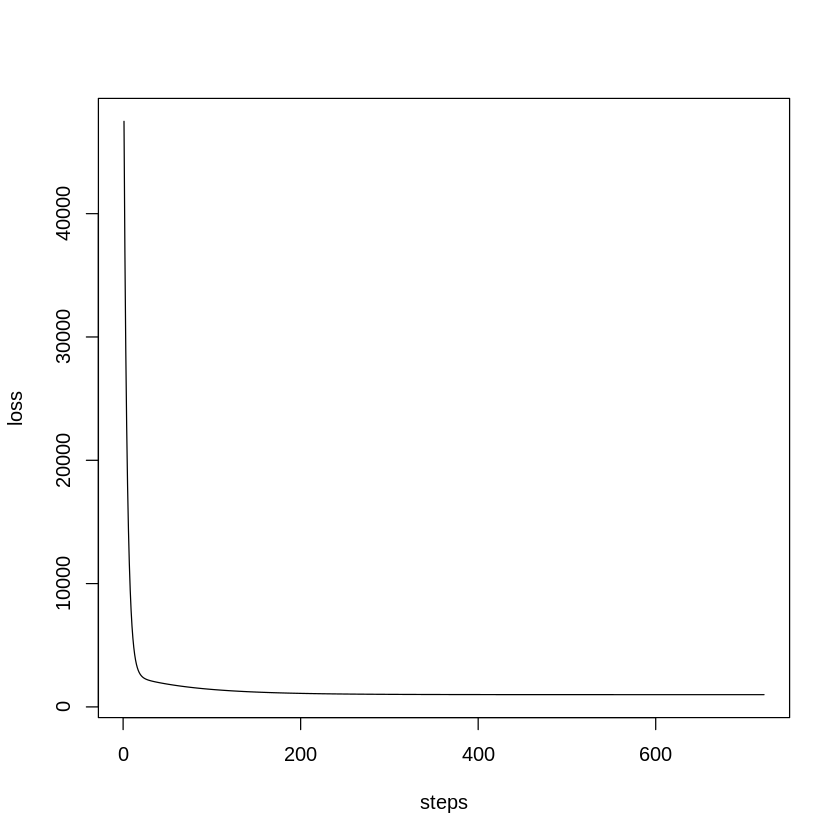

In [136]:
plot(w$history$loss, type = "l", xlab = "steps", ylab = "loss")

Learning path

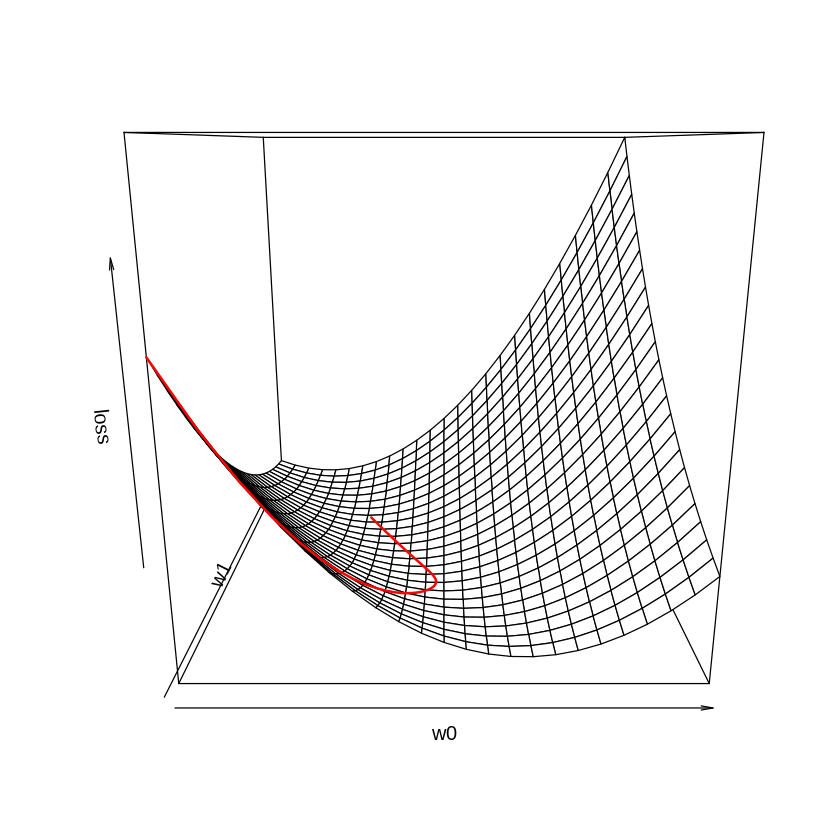

In [137]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
lines(
  trans3d(
    x = w$history[,"w0"]/max(grid[,"w0"]), 
    y = w$history[,"w1"]/max(grid[,"w1"]), 
    z = w$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

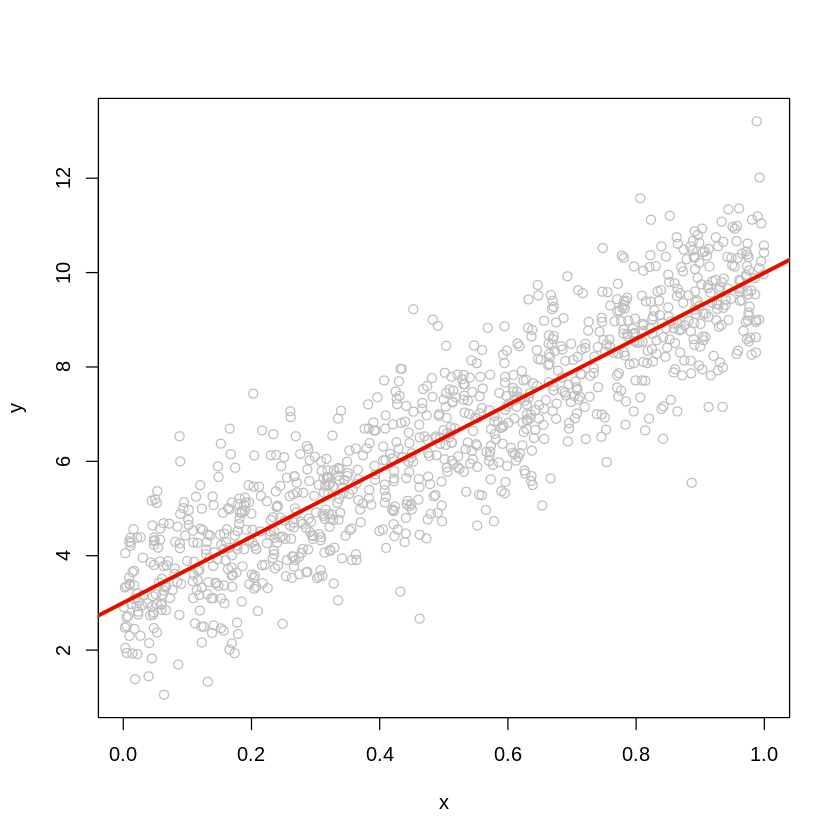

In [138]:
plot(xy, col = "grey")
abline(a = real_w0, b = real_w1, col = "green", lwd = 3)
abline(a = w0, b = w1, col = "red", lwd = 3)

### SGD with minibatch

SGD randomly selects a small number of training examples at each step. The selected examples are called a _minibatch_.  


_Notes:_ 
* Convergence is a problem since loss on all the batch can increase. I use for the convergence check a number of tries with a loss improvement less than eps. I also reduce alpha over time using $\alpha/t^\delta$ for better convergence. 
* The algorithm needs more steps, since each step involves less data. But it typically is till faster on large datasets.

In [139]:
line_SGD <- function(xy, batch_size = 50, alpha = 0.01, delta = 0.25, eps = 1e-1, 
  tries = 10, verbose = FALSE) {
  
  #' start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  # we use loss improvement > eps to check for convergence
  step <- 0
  improvements <- 0
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  
  #' update weights
  while (improvements < tries) {
    old_loss <- loss
    step <- step + 1
    if(verbose) cat("Step: ", step)
      
    mb <- xy[sample(nrow(xy), size = batch_size),]
    w0 <- with(mb, w0 + alpha/step^delta * sum(y - y_hat(x, w0, w1)))
    w1 <- with(mb, w1 + alpha/step^delta * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
    improvement <- old_loss - loss
    if(abs(improvement) < eps) improvements <- improvements + 1
    else improvements <- 0
    
    if(verbose) cat(" - impovement:", improvement, "\n")  
      
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [140]:
w <- line_SGD(xy, batch_size = 50, alpha = 0.01, delta = 0.25, eps = 1e-1, verbose = FALSE) 
w$w

w0       w1 
3.027240 6.954599

Learning curve

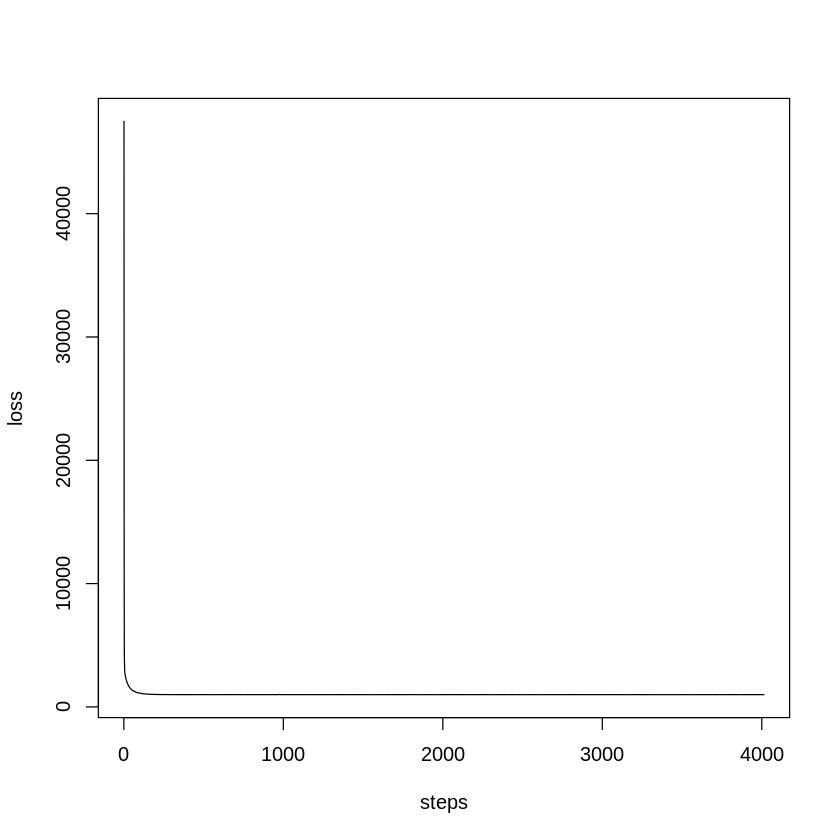

In [141]:
plot(w$history$loss, type = "l", xlab = "steps", ylab = "loss")

Learning path

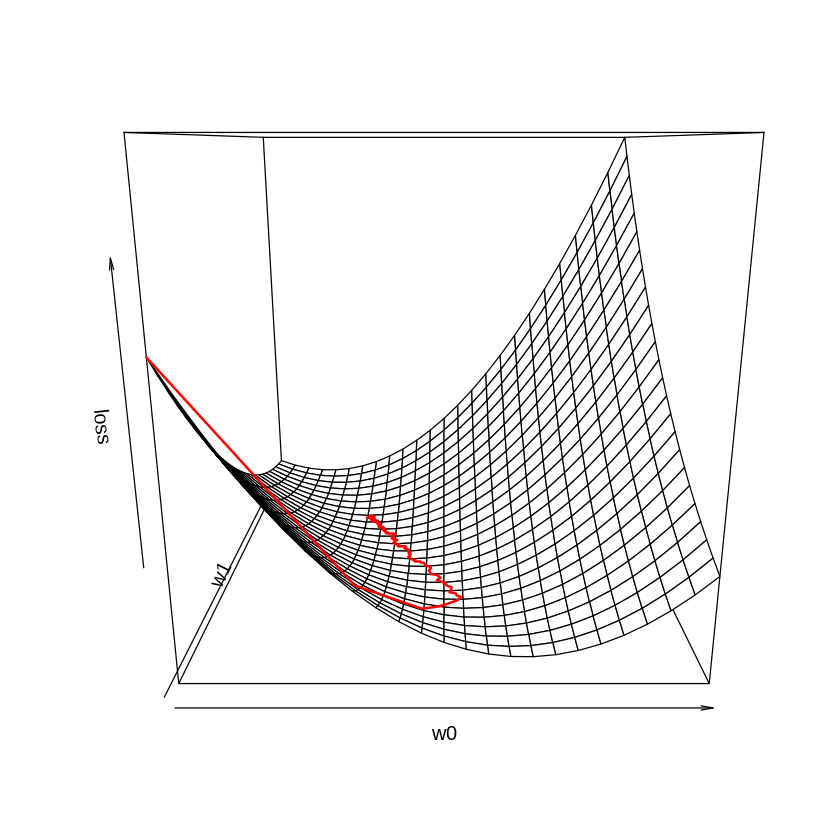

In [142]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
lines(
  trans3d(
    x = w$history[,"w0"]/max(grid[,"w0"]), 
    y = w$history[,"w1"]/max(grid[,"w1"]), 
    z = w$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

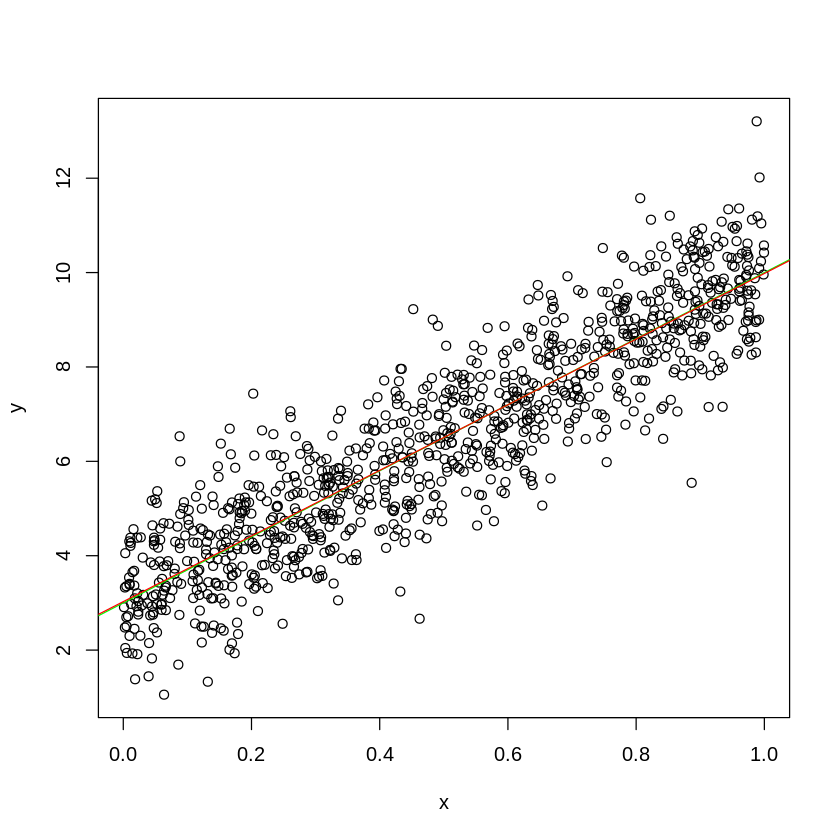

In [143]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")
abline(a = w$w["w0"], b = w$w["w1"], col = "red")